In [211]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("../include/")
import hhtools
import hhsignal

import importlib
from tqdm.notebook import tqdm

In [212]:
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.facecolor"] = "w"

# Check summary 

## Concat simulations

# Full summary 

In [ ]:
obj = hhtools.SummaryLoader("./asym_link_full/")
print(obj.summary["chi"].shape)
print(obj.controls.keys())

# correction
obj.summary["chi"][:,:,:,:,24:48,0] = np.nan

# Single sample test

In [ ]:
data = obj.load_detail(5, 1, 1, 5, 1)

In [ ]:
importlib.reload(hhsignal)

data = obj.load_detail(13, 0, 1, 2, 0)
# data = obj.load_detail(2, 6, 1, 5, 0)

t0 = 2
wbin_t = 1
idt = (data["ts"] >= t0) & (data["ts"] < t0+wbin_t)

cc, tlag = hhsignal.get_correlation(data["vlfp"][1][idt], data["vlfp"][1][idt], 2000, max_lag=0.1)
idp = hhsignal.find_corr_peaks(cc)

plt.figure(figsize=(3, 2))
plt.plot(tlag, cc, 'k')
plt.plot(tlag[idp], cc[idp], 'rp')
print(tlag[idp][1:] * 1e3, cc[idp])
plt.show()

# Full figure 

In [ ]:
import pickle as pkl
with open("./asym_link_full_out.pkl", "rb") as fp:
# with open("./tmp_out.pkl", "rb") as fp:
    order_dyna = pkl.load(fp)

In [ ]:
def draw_pts(rs, cs, npt):
    if npt is None:
        return
    
    cmap = hhtools.get_palette("gray")
    for i, nrc in enumerate(npt):
        nr, nc = nrc[0], nrc[1]
        c = cmap((i+0.5)/len(npt))
        plt.plot(cs[nc], rs[nr], "p", c=c, markersize=5)
        plt.text(cs[nc], rs[nr], "%d"%(i), c=c, fontsize=10)
                 

def generate_full_summary(id_rank, id_p, save=False, pts=None, fdir=None):
    x = obj.controls["beta_set"]
    y = obj.controls["alpha_set"]
    title_fontsize = 15

    def set_axis():
        plt.xticks([0, 0.5, 1])
        plt.yticks(np.arange(0, 2.1, 0.5))
        return plt.colorbar()

    w = 15
    tags = ["T", "F", "S"]
    fig = plt.figure(dpi=200, figsize=(w, w*np.sqrt(2)))

    # Firing rate
    for n in range(3):
        im = obj.summary["frs_m"][:,:,id_rank,id_p,:,n]

        plt.subplot(8,4,n+1)
        hhtools.imshow_xy(np.average(im, 2), x=x, y=y, cmap="jet", vmin=0, vmax=10)
        plt.title("E(fr(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

        plt.subplot(8,4,n+5)
        # hhtools.imshow_xy(np.average(obj.summary["frs_s"][:,:,id_rank,id_p,:,n], 2), x=x, y=y, cmap="jet", vmin=0)
        hhtools.imshow_xy(np.std(im, 2), x=x, y=y, cmap="jet", vmin=0)
        plt.title(r"$\sigma$(fr(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)
                 
    # CV
    labels = ["CV(F)", "CV(S)"]
    for n in range(2):
        cv = obj.summary["cv"][:,:,id_rank,id_p,:,:]
        plt.subplot(8,4,(n+1)*4)
        hhtools.imshow_xy(np.average(cv[:,:,:,n+1], 2), x=x, y=y, cmap="jet", vmin=0, vmax=1)
        plt.title(labels[n], fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

    # chi
    for n in range(3):
        # -----------------------------------------------
        im = obj.summary["chi"][:,:,id_rank,id_p,:,n]
        
        # -----------------------------------------------

        plt.subplot(8,4,n+9)
        hhtools.imshow_xy(np.nanmean(im, 2), x=x, y=y, cmap="jet", vmin=0, vmax=0.8)
        plt.title(r"E($\chi$(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

        plt.subplot(8,4,n+13)
        hhtools.imshow_xy(np.nanstd(im, 2), x=x, y=y, cmap="jet", vmin=0)
        plt.title(r"$\sigma$($\chi$(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

    # AC2
    for n in range(3):
        im = order_dyna["ac2_p"][:,:,id_rank,id_p,:,n]
        # show AC2 average
        plt.subplot(8,4,n+17)
        hhtools.imshow_xy(np.average(im, axis=2), cmap="jet", x=x, y=y, vmin=0, vmax=0.8)
        plt.title(r"E(AC2(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)
        # show AC2 std
        plt.subplot(8,4,n+21)
        hhtools.imshow_xy(np.std(im, axis=2), cmap="jet", x=x, y=y)
        plt.title(r"$\sigma$(AC2(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

    # frequency
    for n in range(3):
        im = 1/order_dyna["ac2_lag"][:,:,id_rank,id_p,:,n]

        plt.subplot(8,4,n+25)
        hhtools.imshow_xy(np.average(im, axis=2), cmap="jet", x=x, y=y, vmin=20, vmax=80)
        plt.title(r"E(f(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

        plt.subplot(8,4,n+29)
        hhtools.imshow_xy(np.std(im, axis=2), cmap="jet", x=x, y=y)
        plt.title(r"$\sigma$(f(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

    # CC
    im = order_dyna["cc_p"][:,:,id_rank,id_p,:]
    plt.subplot(8,4,20)
    hhtools.imshow_xy(np.average(im, axis=2), cmap="jet", x=x, y=y, vmin=0, vmax=0.8)
    plt.title(r"E(CC(F-S))", fontsize=title_fontsize)
    set_axis()
    draw_pts(y, x, pts)
    
    # show CC - std
    plt.subplot(8,4,24)
    hhtools.imshow_xy(np.std(im, axis=2), cmap="jet", x=x, y=y, vmin=0)
    plt.title(r"$\sigma$(CC(F-S))", fontsize=title_fontsize)
    set_axis()
    draw_pts(y, x, pts)
    
    # show lead/lag ratio
    plt.subplot(8,4,28)
    t_cc = order_dyna["cc_lag"][:,:,id_rank,id_p,:]
    pos_ratio = np.sum(t_cc > 0, axis=2) / t_cc.shape[2]*2-1
    hhtools.imshow_xy(pos_ratio, cmap="RdBu", x=x, y=y, vmin=-1, vmax=1)
    plt.title("Ratio of leading", fontsize=title_fontsize)
    cbar = set_axis()
    cbar.ax.set_yticks([-1, 0, 1])
    cbar.ax.set_yticklabels(['F>', '0', 'S>'])

    # dphs
    tol = 0.1
    plt.subplot(8,4,32)
    dphs = np.zeros_like(pos_ratio)
    # fast lead
    ind_f = pos_ratio < -tol
    T_f = order_dyna["ac2_lag"][:,:,id_rank,id_p,:,1]
    dphs[ind_f] = np.average(t_cc[ind_f,:] / T_f[ind_f,:], axis=1)

    # lead/lag relation 
    ind_s = pos_ratio > tol
    T_s = order_dyna["ac2_lag"][:,:,id_rank,id_p,:,2]
    dphs[ind_s] = np.average(t_cc[ind_s,:] / T_s[ind_s,:], axis=1)

    hhtools.imshow_xy(dphs, cmap="jet", vmin=-0.1, vmax=0.05, x=x, y=y)
    plt.title(r"$t_{lag,cc}/T_{leader}$", fontsize=title_fontsize)
    set_axis()
    draw_pts(y, x, pts)
    
    # show amount of leading
    plt.subplot(8,4,12)
    plt.ylabel(r"$\alpha$ (ratio of E proj)", fontsize=14)
    plt.xlabel(r"$\beta$ (ratio of I proj)", fontsize=14)
    plt.xlim([0, 1])
    plt.ylim([0, 2])
    plt.xticks([0, 0.5, 1])
    plt.yticks(np.arange(0, 2.1, 0.5))
    plt.title("id_rank=%d, p_ratio=%.2f"%(id_rank, obj.controls["p_ratio_set"][id_p]), fontsize=title_fontsize)
    draw_pts(y, x, pts)
    # plt.axis("off")

    plt.tight_layout()
    if save:
        if fdir is None:
            fdir = "./"
        if pts is None:
            plt.savefig(os.path.join(fdir, "asym_summary_r%d_pr%.2f.pdf"%(id_rank, obj.controls["p_ratio_set"][id_p])))
        else:
            plt.savefig(os.path.join(fdir, "asym_summary_r%d_pr%.2f_samples.pdf"%(id_rank, obj.controls["p_ratio_set"][id_p])))

    # plt.show()
    return fig

In [ ]:
for idr in range(2):
    for idp in range(7):
        fig = generate_full_summary(idr, idp, save=True, pts=None, fdir="figures_new")

In [ ]:
pts_check = [
    [13, 1],
    [5, 1],
    [2, 6],
    [2, 8]]

idr = 1
idp = 5

fig = generate_full_summary(idr, idp, save=False, pts=pts_check)

# fdir = "./check_idr=%d_pr=%.2f"%(idr, obj.controls["p_ratio_set"][idp])
# if not os.path.isdir(fdir):
#     os.mkdir(fdir)
#     plt.savefig(os.path.join(fdir, "summary.png"))
#     plt.show()

In [116]:
print(1/order_dyna['ac2_lag'][0,0,0,0,0,1])

14.184397163120522


In [114]:
print(order_dyna['ac2_lag'].shape)

(15, 15, 2, 7, 900, 3)


13.333333333333291
[ 13.24503311 -13.24503311] [0.99999999 0.19637395 0.19637394]


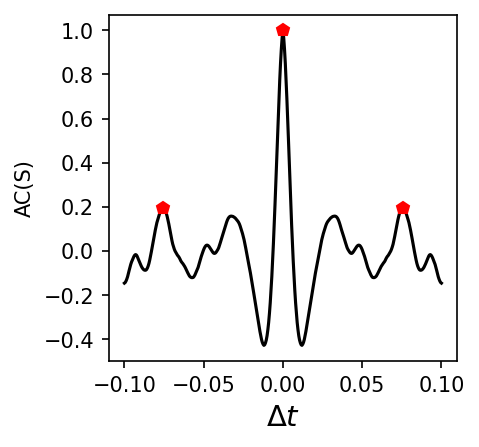

In [162]:
importlib.reload(hhsignal)

data = obj.load_detail(0, 0, 0, 3, 3)

print(1/order_dyna['ac2_lag'][0,0,0,5,500,1])

# data = obj.load_detail(2, 6, 1, 5, 0)

t0 = 2
wbin_t = 1
idt = (data["ts"] >= t0) & (data["ts"] < t0+wbin_t)

cc, tlag = hhsignal.get_correlation(data["vlfp"][1][idt], data["vlfp"][1][idt], 2000, max_lag=0.1)
idp = hhsignal.find_corr_peaks(cc)

plt.figure(figsize=(3, 3))
plt.plot(tlag, cc, 'k', label="AC(S)")
plt.plot(tlag[idp], cc[idp], 'rp', label="modified")
# plt.legend(fontsize=10, loc="upper left")
print(1/(tlag[idp][1:]), cc[idp])
plt.xlabel(r"$\Delta t$", fontsize=14)
plt.ylabel("AC(S)")
plt.show()

In [177]:
from scipy.signal import find_peaks
from scipy.signal import correlate

ind_peaks, _ = find_peaks(cc)

array([-93. , -75.5, -48. , -32.5,   0. ,  32.5,  48. ,  75.5,  93. ])
array([-0.016,  0.196,  0.027,  0.158,  1.   ,  0.158,  0.027,  0.196,
       -0.016])


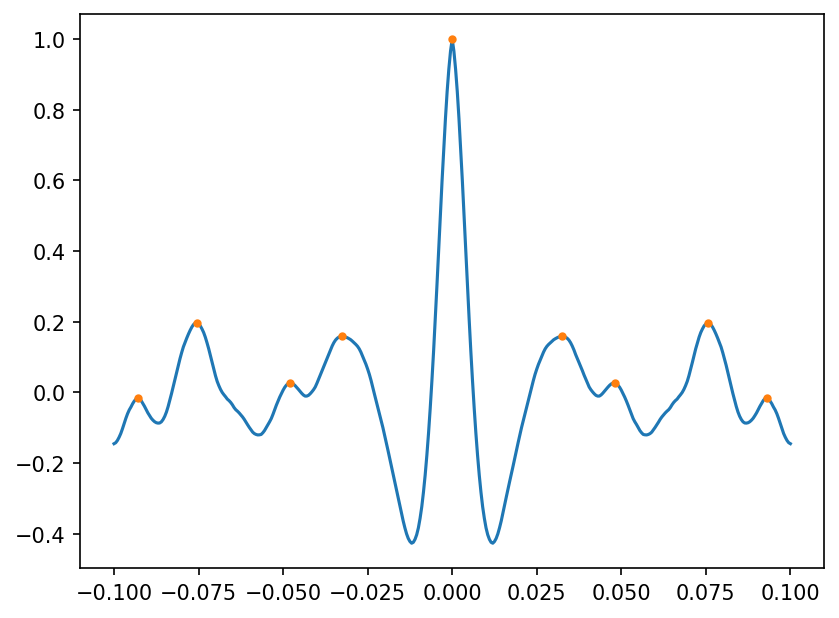

In [176]:
from pprint import pprint

plt.figure()
plt.plot(tlag, cc)
plt.plot(tlag[ind_peaks], cc[ind_peaks], '.')
pprint(np.round(tlag[ind_peaks]*1e3, 1))
pprint(np.round(cc[ind_peaks], 3))

40.816326530612244


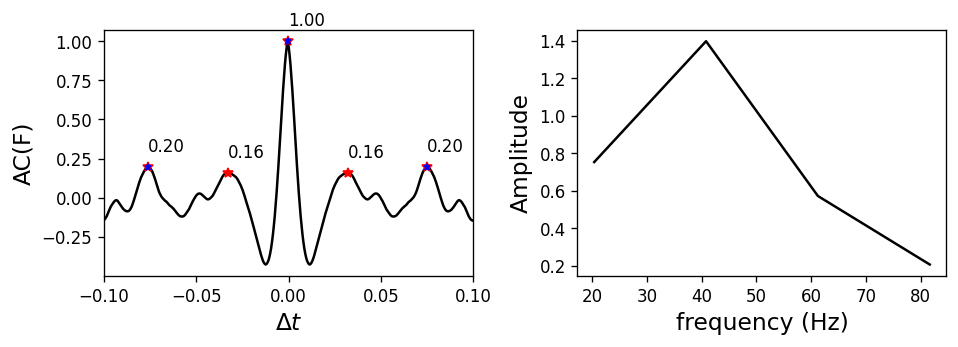

In [228]:
data = obj.load_detail(0, 0, 0, 3, 3)
# data = obj.load_detail(2, 6, 1, 5, 0)

t0 = 2
wbin_t = 1
idt = (data["ts"] >= t0) & (data["ts"] < t0+wbin_t)
x = data["vlfp"][1][idt]

cc_tmp = correlate(x-np.average(x), x-np.average(x), mode="full", method="fft")
cc_tmp = cc_tmp / np.var(x) / len(x)
ind_peaks, _ = find_peaks(cc_tmp)
nid = np.argsort(cc_tmp[ind_peaks])[::-1]
ind_peaks = ind_peaks[nid[:5]]

plt.figure(dpi=120, figsize=(8, 3))

plt.subplot(121)
t = np.arange(-len(cc_tmp)//2, len(cc_tmp)//2)/2000
plt.plot(t, cc_tmp, 'k')
plt.plot(t[ind_peaks], cc_tmp[ind_peaks], 'r*', ms=6)
plt.plot(t[ind_peaks[:3]], cc_tmp[ind_peaks[:3]], 'b*', ms=4)

for n in ind_peaks:
    plt.text(t[n], cc_tmp[n]+0.1, "%.2f"%(cc_tmp[n]))
plt.xlim([-0.1, 0.1])
plt.xlabel(r"$\Delta t$", fontsize=14)
plt.ylabel("AC(F)", fontsize=14)

plt.subplot(122)
yf, f = hhsignal.get_fft(x, 2000, frange=[3, 100], nbin=100)
plt.plot(f, yf, 'k')
plt.xlabel("frequency (Hz)", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)

print(f[np.argmax(yf)])

plt.tight_layout()
plt.show()

2000

In [181]:
cc_tmp = correlate(x-np.average(x), x-np.average(x), mode="full", method="fft")

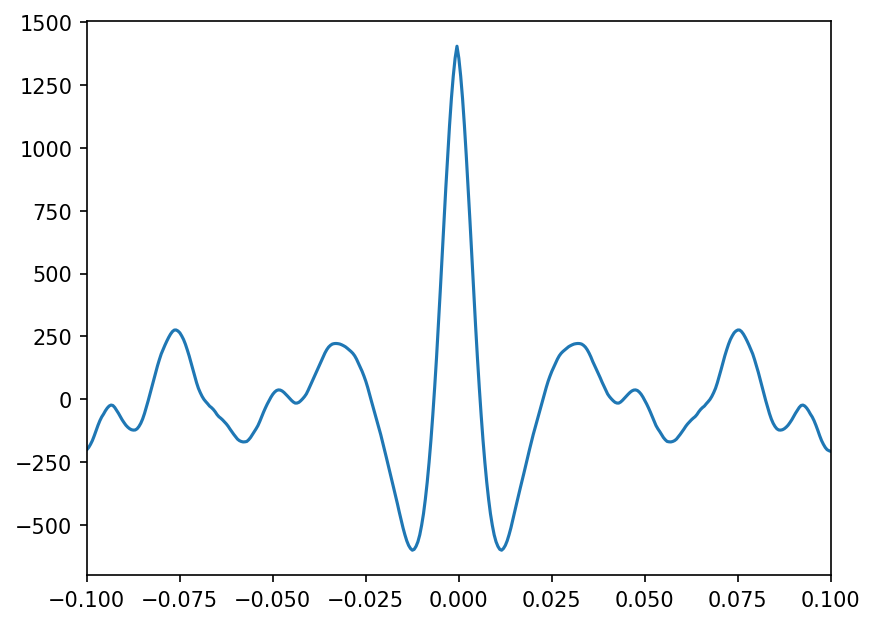

In [185]:
t = np.arange(-len(cc_tmp)//2, len(cc_tmp)//2)/2000

plt.figure()
plt.plot(t, cc_tmp)
plt.xlim([-0.1, 0.1])cc_tmp = correlate(x-np.average(x), x-np.average(x), mode="full", method="fft")
plt.show()

In [178]:
x = data["vlfp"][1][idt]

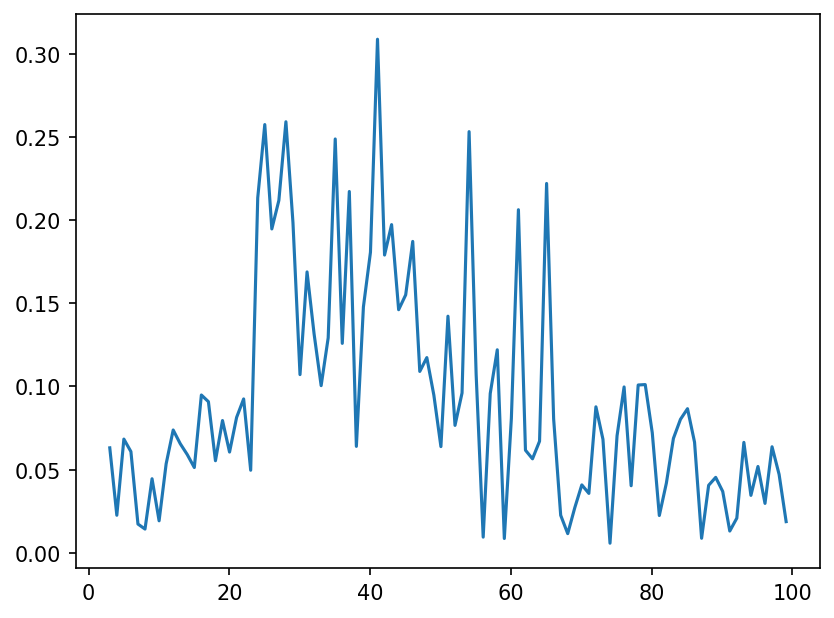

In [161]:
yf, f = hhsignal.get_fft(data["vlfp"][1][idt], 2000, frange=[3, 100])

plt.figure()
plt.plot(f, yf)
plt.show()

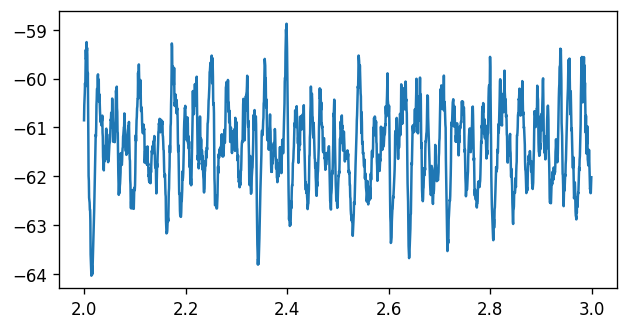

In [146]:
plt.figure(dpi=120, figsize=(6, 3))
plt.plot(data["ts"][idt], data["vlfp"][1][idt])
plt.show()

In [153]:
psd, ff, tf = hhsignal.get_stfft(data["vlfp"][1], data["ts"], 2000, f_range=[3, 100])

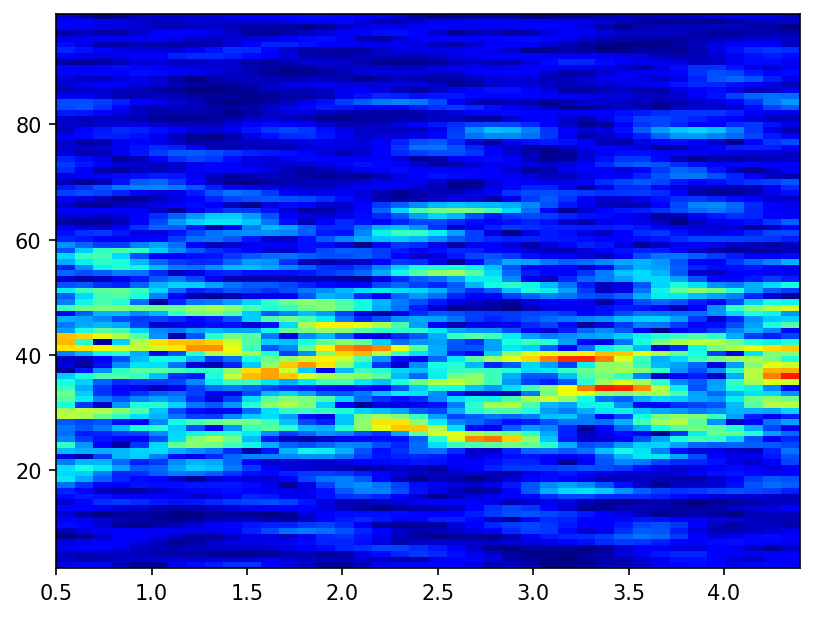

In [158]:
plt.figure()
hhtools.imshow_xy(psd, x=tf, y=ff, cmap="jet", vmax=0.3)
plt.show()

In [ ]:
importlib.reload(hhsignal)

data = obj.load_detail(2, 8, 1, 5, 3)
# data = obj.load_detail(2, 6, 1, 5, 0)

t0 = 2
wbin_t = 1
idt = (data["ts"] >= t0) & (data["ts"] < t0+wbin_t)

cc, tlag = hhsignal.get_correlation(data["vlfp"][2][idt], data["vlfp"][2][idt], 2000, max_lag=0.1)
idp = hhsignal.find_corr_peaks(cc)
idp_old = hhsignal.find_corr_peaks_old(cc)

plt.figure(figsize=(3, 3))
plt.plot(tlag, cc, 'k', label="AC(S)")
plt.plot(tlag[idp], cc[idp], 'rp', label="modified")
plt.plot(tlag[idp_old], cc[idp_old], 'bp', label="old ver")
plt.legend(fontsize=10, loc="upper left")
print(tlag[idp][1:] * 1e3, cc[idp])
plt.xlabel(r"$\Delta t$", fontsize=14)
plt.ylabel("AC(S)")

plt.savefig("./figures/AC_change.png")
plt.show()

# Probe Single samples 

In [ ]:
for nn, pts in enumerate(pts_check):
    nr, nc = pts
    
    data = obj.load_detail(nr, nc, idr, idp, 0)

    xl = [2000, 3000]
    c_set = ["k", "r", "g"]
    lbs = ["T", "F", "S"]

    plt.figure(figsize=(9, 5.5))
    ax1 = plt.axes([0.1, 0.65, 0.55, 0.3])
    hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=xl)

    ax2 = plt.axes([0.1, 0.48, 0.55, 0.152])
    t = data["ts"] * 1e3
    for i in range(3):
        plt.plot(t[500:], data["vlfp"][i][500:], c_set[i])
    plt.xlim(xl)

    ax3 = plt.axes([0.1, 0.1, 0.55, 0.3])
    yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)
    hhtools.imshow_xy(yfft, x=t*1e3, y=f, cmap="jet", interpolation="spline16", vmax=1, vmin=0)
    plt.xlabel("time (ms)", fontsize=15)
    plt.colorbar()

    ax4 = plt.axes([0.75, 0.6, 0.2, 0.35])
    t = data["ts"] * 1e3
    idt = (t >= xl[0]) & (t <= xl[1])

    for i in range(3):
        v = data["vlfp"][i][idt]
        cc, tlag = hhsignal.get_correlation(v, v, 2000, max_lag=0.1)
        plt.plot(tlag, cc, c=c_set[i], label=lbs[i])
    plt.xlim([-0.1, 0.1])
    plt.ylabel("AC2")
    plt.legend(fontsize=8, ncol=3)

    ax5 = plt.axes([0.75, 0.1, 0.2, 0.35])

    cc, tlag = hhsignal.get_correlation(data["vlfp"][1][idt], data["vlfp"][2][idt], 2000, max_lag=0.1)

    plt.plot(tlag, cc, 'k')
    plt.xlim([-0.1, 0.1])
    plt.ylim([-1, 1])
    plt.ylabel("CC1(F, S)")
    
    pr = obj.controls["p_ratio_set"]
    plt.suptitle("id_r=%d, pr=%.2f, pts=%d"%(idr, pr[idp], nn))
    
    
    # plt.savefig(os.path.join(fdir, "sample_%d.png"%(nn)))
    plt.show()
    

In [ ]:
data = obj.load_detail(5, 10, 1, 0, 0)

xl = [2000, 3000]
c_set = ["k", "r", "g"]
lbs = ["T", "F", "S"]

plt.figure(figsize=(9, 4))
ax1 = plt.axes([0.1, 0.65, 0.55, 0.3])
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=xl)

ax2 = plt.axes([0.1, 0.48, 0.55, 0.152])
t = data["ts"] * 1e3
for i in range(3):
    plt.plot(t[500:], data["vlfp"][i][500:], c_set[i])
plt.xlim(xl)

ax3 = plt.axes([0.1, 0.1, 0.55, 0.3])
yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)
hhtools.imshow_xy(yfft, x=t*1e3, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (ms)", fontsize=15)

ax4 = plt.axes([0.75, 0.6, 0.2, 0.35])
t = data["ts"] * 1e3
idt = (t >= xl[0]) & (t <= xl[1])

for i in range(3):
    v = data["vlfp"][i][idt]
    cc, tlag = hhsignal.get_correlation(v, v, 2000, max_lag=0.1)
    plt.plot(tlag, cc, c=c_set[i], label=lbs[i])
plt.xlim([-0.1, 0.1])
plt.ylabel("AC2")
plt.legend(fontsize=8, ncol=3)

ax5 = plt.axes([0.75, 0.1, 0.2, 0.35])

cc, tlag = hhsignal.get_correlation(data["vlfp"][1][idt], data["vlfp"][2][idt], 2000, max_lag=0.1)

plt.plot(tlag, cc, 'k')
plt.xlim([-0.1, 0.1])
plt.ylabel("CC1(F, S)")

plt.show()

# Generate Single figure 

In [ ]:
data = obj.load_detail(0, 0, 0, 0, 0)

In [ ]:
# seq = np.random.randint(low=0, high=2000, size=100)
seq = np.random.choice(np.arange(2000), size=100, replace=False)

In [ ]:
hhtools.draw_spk(data["step_spk"], dt=0.01, colors='k', sequence=seq)

In [ ]:
data.keys()

In [ ]:
plt.figure()
for t in obj.t_s

In [ ]:
np.random.seed(100)

plt.figure(dpi=120, figsize=(8, 4sequence=




In [ ]:
id_r = 1
id_p = 3


xp = [x[nc] for nc in [3, 10]]
yp = [y[nr] for nr in [7, 4]]


plt.figure(figsize=(15, 20))
for n in range(3):
        im = 1/order_dyna["ac2_lag"][:,:,id_r,id_p,:,n]

        plt.subplot(8,4,n+25)
        hhtools.imshow_xy(np.average(im, axis=2), cmap="jet", x=x, y=y)
        plt.title(r"E(f(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        plt.plot(xp, yp, "wp", ms=10)

        plt.subplot(8,4,n+29)
        hhtools.imshow_xy(np.std(im, axis=2), cmap="jet", x=x, y=y)
        plt.title(r"$\sigma$(f(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        plt.plot(xp, yp, "wp", ms=10)

In [ ]:
obj.control_names

In [ ]:
data = obj.load_detail(4,10,id_r,id_p,0)

In [ ]:
# data = obj.load_detail(12, 2, 2, 0)

plt.figure(dpi=120, figsize=(8, 3))
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(2500, 3000))

yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)
plt.figure(dpi=120, figsize=(6, 3))
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

In [ ]:
plt.figure(dpi=120, figsize=(6, 4))


# plt.plot(data["vlfp"][0])
# plt.plot(data["vlfp"][0])
# plt.plot(data["vlfp"][0])

In [ ]:
title_fontsize

In [ ]:
id_rank = 1
id_w = 1
n = 0

def logistic(x):
    return np.exp((x-1/2)*10)/(1+np.exp((x-1/2)*10))

im = np.average(1/order_dyna["ac2_lag"][:,:,id_rank,id_w,:,n], axis=2)

alpha = np.std(1/order_dyna["ac2_lag"][:,:,id_rank,id_w,:,n], axis=2)
alpha = (alpha - np.min(alpha)) / (np.max(alpha) - np.min(alpha))
alpha = logistic(alpha)


# hhtools.imshow_xy(, cmap="jet", x=x, y=y)

plt.figure(figsize=(9, 3))
plt.subplot(131)
hhtools.imshow_xy(im, x=x, y=y, alpha=alpha, cmap="jet")
plt.subplot(132)
hhtools.imshow_xy(im, x=x, y=y, cmap="jet")
plt.subplot(133)
hhtools.imshow_xy(alpha, x=x, y=y, cmap="jet")

In [ ]:
np.std(alpha)

In [ ]:
np.mean(alpha)

In [ ]:
np.max(alpha)

In [ ]:
np.min(alpha)

In [ ]:
id_w = 0
id_rank = 0

x = obj.controls["beta_set"]
y = obj.controls["alpha_set"]

def set_label():
    plt.xlabel(r"$\beta$", fontsize=15)
    plt.ylabel(r"$\alpha$", fontsize=15)
    plt.xticks([0, 0.5, 1])
    plt.yticks(np.arange(0, 2.1, 0.5))
    
plt.figure(
    

plt.figure(dpi=120, figsize=(12.5, 7))


for n in range(3):
    plt.subplot(2,3,n+1)
    hhtools.imshow_xy(np.average(order_dyna["cc_p"][:,:,id_rank,id_w,:,n], axis=2), cmap="jet", x=x, y=y, vmin=0)
    plt.colorbar()
    set_label()
    
    plt.subplot(2,3,n+4)
    hhtools.imshow_xy(np.std(order_dyna["cc_p"][:,:,id_rank,id_w,:,n], axis=2), cmap="jet", x=x, y=y)
    plt.colorbar()
    set_label()
    
plt.tight_layout()
plt.show()

In [ ]:
order_dyna["ac_p"].s

In [ ]:
id_w = 0

plt.figure(figsize=(5,5))
# plt.imshow(np.average(np.abs(1/order_dyna["ac_lag"][:,:,id_rank,id_w,:,ntp]), axis=2), cmap="jet")
plt.imshow(np.average(order_dyna["cc_lag"][:,:,id_rank,id_w,:], axis=2), cmap="jet", vmin=-0.005, vmax=0.001)
plt.colorbar()
plt.show()

In [ ]:
order_dyna["ac_p"].shape

In [ ]:
obj.controls["beta_set"][0]

In [ ]:
id_rank = 1
id_w = 0
ntp = 2

plt.figure(figsize=(4,4))
plt.imshow(np.average(np.abs(1/order_dyna["ac_lag"][:,:,id_rank,id_w,:,ntp]), axis=2), cmap="jet")
plt.colorbar()
plt.show()

In [ ]:
im = np.random.rand(100, 100)
alpha = np.zeros([100, 100]) + 0.05
alpha[25:75,25:75] = 0.9

In [ ]:
plt.figure()
plt.imshow(im, alpha=alpha)
plt.show()

In [ ]:
data.keys()

# Single sample test 

In [ ]:
yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 150), wbin_t=0.5, mbin_t=0.01)

plt.figure(dpi=120, figsize=(6, 3))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

## Raster plot 

In [ ]:
data = obj.load_detail(14, 1, 2, 0, 0)

plt.figure(dpi=120, figsize=(4, 4))
plt.subplot(211)
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(2000, 2500))
plt.xticks([])

plt.subplot(212)
nid = np.random.choice(np.arange(2000), size=1000, replace=False)
step_tmp = []
for n in nid:
    step_tmp.append(data["step_spk"][n])
hhtools.draw_spk(step_tmp, color_ranges=None, xl=(2000, 2500))

plt.show()